# Module 8 - ML, XAI, and data analytics

## Machine Learning - Neural Networks Image Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
sns.set()

# Numerical Data Manipulation libraries
import pandas as pd
import numpy as np
import statistics as stat


# Naive Bayes libraries
import sklearn
from sklearn.naive_bayes import BernoulliNB      # Naive Bayes Classifier based on a Bernoulli Distribution
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Text Analysis libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [2]:
def predict( model, image, print_img ):
    
    if( print_img ):
        plt.grid(b=None)
        plt.imshow(image)
    
    n_image = np.expand_dims(image, axis=0)
    n_image = np.expand_dims(n_image, axis=3)
    
    prediction = model.predict( n_image )[0]
    
    if( prediction >= 0.5 ):
        if( print_img ):
            print('Model Prediction: CRIMINAL with probability = %.2f' % prediction)
        result = 1
    else:
        if( print_img ):
            print('Model Prediction: NOT CRIMINAL with probability = %.2f' % prediction)
        result = 0
        
    return result

def check_image_dataset( dataset, class_var ):
    
    last_pixels = dataset[["pixel_4092", "pixel_4093", "pixel_4094", "pixel_4095", class_var]]
    return last_pixels
    
    
    

## Neural Networks for Face Recognition

In this part of the workshop, we will see how we can apply the principles of Deep Learning to more complex datasets, like images.

Let's suppose that we have a dataset with faces of people with / and without crimial records. Like the paper that was presented in last workshop, we are going to try to use a very simple neural network to try to find patterns in faces that are considered criminals from those who are not.

Note: this is a toy dataset. It does not represent any reality. We collected a public research dataset with human faces and randomly labelled them as *Criminal* and *Not Criminal* for learning purposes.

In [3]:
faces_dataset = pd.read_csv('data/dataset_64_v2.csv', delimiter=',')

In [4]:
faces_dataset.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,target
0,253,253,253,253,253,253,253,253,253,253,...,25,39,40,39,42,0,0,0,0,1
1,89,66,21,16,19,35,47,47,41,36,...,188,187,155,129,163,177,171,169,162,0
2,237,236,238,239,239,241,241,237,222,193,...,30,30,31,29,33,0,0,0,0,1
3,218,210,201,207,202,181,172,193,195,201,...,1,1,1,1,1,1,1,1,1,0
4,143,155,182,187,182,166,113,64,55,59,...,42,56,63,59,60,0,0,0,0,1


In [5]:
# total number of images in dataset:
num_images = len(faces_dataset)
num_pixels = len(faces_dataset.columns) - 1

print('Total number of images in the dataset is: ' + str(num_images))
print('Total number of pixels per image is: ' + str(num_pixels))

Total number of images in the dataset is: 2142
Total number of pixels per image is: 4096


In [6]:
# We can also try to understand what is the distribution of criminals / not crimials in our dataset:
criminals = faces_dataset[ faces_dataset['target'] == 1 ]
not_criminals = faces_dataset[ faces_dataset['target'] == 0 ]

print('Criminality distribution:')
print('Number of criminals: ' + str(len(criminals)))
print('Number of not criminals: ' + str(len(not_criminals)))

Criminality distribution:
Number of criminals: 1049
Number of not criminals: 1093


This dataset is a set of pixels. More precesely, each image corresponds to a row and each image contains a total of 9216 pixels. This means that the image has a size of 96x96. The last colum **target** specifies if the face is associated to someone who has crimial records *target=1* or to someone who does not have any crminal records *target=0*.

Let's see if we can visualize the images...

Image label = NOT CRIMINAL


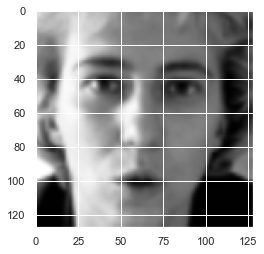

In [7]:
# getting some images... 
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

indx = 3
image_0 = faces_dataset.iloc[indx,0:num_pixels]

# image_0 is a vector with 9216 pixels. In order to convert it into an image,
# we need to reshape this vector into a matrix of 96*96 = 9216 pixels

image_0 =  np.array(image_0)
image_0 = np.reshape(image_0, (64, 64))
image_0 = resize(image_0, (128, 128), anti_aliasing=True)

# show image
plt.imshow(image_0,  cmap=plt.cm.gray )

# print target
if( faces_dataset.iloc[indx,num_pixels] == 1):
    print('Image label = CRIMINAL')
else:
    print('Image label = NOT CRIMINAL')

## Machine Learning for Face Recognition

The approach we are going to use for facial recognition is very straight forward but you could check this out in the case of a very complicated problem. Let’s learn how modern face recognition works!

The goal here is to get deep neural network to output a person’s face with identification. This means that the neural network needs to be trained to automatically identify different features of a face and calculate numbers based on that. The output of the neural network can be thought of as an identifier for a particular person's face: in this case, if the person represents a criminal or not.

### Convolutional Neural Network

In machine learning, a Convolutional Neural Network (CNN or ConvNet) is a class of artificial neural networks that has successfully been applied to analyzing visual imagery. They have applications in image recognition (facial recognition) and video analysis, recommender systems and natural language processing. Here, facial recognition would be analysed.

The name *convolutional* comes preisely from a mathematical operation that is called the *convolution operator*. This operator is able to convolute an image based on a kernel, which can detect vertical edges, horizontal edges,faces, eyes, etc. The following figure shows an example of a convolution:

<img src='https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-conv2d/keras_conv2d_padding.gif' />
A 3×3 kernel applied to an image. This animation was contributed to StackOverflow (<a href="https://stackoverflow.com/questions/52067833/how-to-plot-an-animated-matrix-in-matplotlib">source</a>).

In [8]:
all_images = []

WIDTH = 64
HEIGHT = 64

data = faces_dataset.iloc[:,0:num_pixels]
for indx in range(0, len(data)):
    
    image = np.array(data.iloc[indx,0:num_pixels])
    # normalise pixels
    temp = np.reshape(image, (WIDTH, HEIGHT))/255.0
    all_images.append(temp)

# convert structure to array
all_images = np.array(all_images)


In [9]:
# separate your dataset: 
# put the variable that you wish to classify (the target) in one variable
# put your features (the pixels) in another variable
X=np.zeros((num_images,WIDTH,HEIGHT,1))
X[:,:,:,0]=all_images
y = faces_dataset.iloc[:,num_pixels]

In [10]:
# separate the dataset into test set and train set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3 )

There are many layers that can be used in deep learning networks.
In image data, we use convolutional layers, and to avoid overfitting, we use MaxPooling and Dropout. 
Very generaly, MaxPooling is a way to reduce the size of your image through a process of discretization.
The Dropout layer corresponds to a random discard of data. This is good, because deep neural networks tend to overfit (or learn the training data by heart). By discarding training elements randomly, we are helping to reduce the overfitting.

In [11]:
# define model
model_deep = Sequential()

# add layers
model_deep.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(WIDTH, HEIGHT, 1)))
model_deep.add(MaxPool2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))

model_deep.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(WIDTH, HEIGHT, 1)))
model_deep.add(MaxPool2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))
model_deep.add(Flatten())

model_deep.add(Dense(256, activation='tanh'))

model_deep.add(Dense(1, activation='sigmoid'))

In [12]:
# visualise the model
model_deep.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

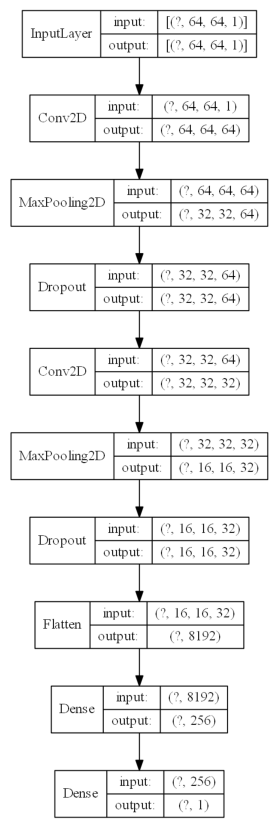

In [13]:
# another way of visualising the network

from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

plot_model(model_deep, "model_dnn.png", show_shapes=True, show_layer_names=False, rankdir='TB', dpi=150)
img = mpimg.imread("model_dnn.png")
plt.figure(figsize=(10,15))
plt.axis('off');
plt.imshow(img)


In [14]:
# compile model
# SGD = Stochastic Gradient Descent
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_deep.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [15]:
# fit model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
history_deep = model_deep.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 1499 samples, validate on 643 samples
Epoch 1/10
1499/1499 [==============================] - 4s 2ms/sample - loss: 0.3245 - accuracy: 0.5037 - val_loss: 0.2490 - val_accuracy: 0.4977
Epoch 2/10
1499/1499 [==============================] - 2s 1ms/sample - loss: 0.2077 - accuracy: 0.7345 - val_loss: 0.1083 - val_accuracy: 0.8974
Epoch 3/10
1499/1499 [==============================] - 2s 1ms/sample - loss: 0.0629 - accuracy: 0.9313 - val_loss: 0.0315 - val_accuracy: 0.9673
Epoch 4/10
1499/1499 [==============================] - 2s 1ms/sample - loss: 0.0342 - accuracy: 0.9526 - val_loss: 0.0226 - val_accuracy: 0.9720
Epoch 5/10
1499/1499 [==============================] - 2s 1ms/sample - loss: 0.0268 - accuracy: 0.9646 - val_loss: 0.0245 - val_accuracy: 0.9658
Epoch 6/10
1499/1499 [==============================] - 2s 2ms/sample - loss: 0.0222 - accuracy: 0.9733 - val_loss: 0.0180 - val_accuracy: 0.9751
Epoch 7/10
1499/1499 [==============================] - 3s 2ms/sample - loss:

In [16]:
# evaluate the model
_, train_acc_deep = model_deep.evaluate(X_train, y_train, verbose=0)
_, test_acc_deep = model_deep.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc_deep, test_acc_deep))

Train: 0.991, Test: 0.978


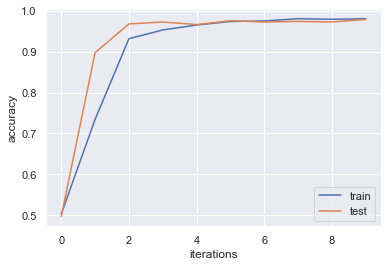

In [17]:
# plot training history
pyplot.plot(history_deep.history['accuracy'], label='train')
pyplot.plot(history_deep.history['val_accuracy'], label='test')
pyplot.ylabel('accuracy', fontsize=12)
pyplot.xlabel('iterations', fontsize=12)
pyplot.legend()
pyplot.show()

Model Prediction: CRIMINAL with probability = 1.00


1

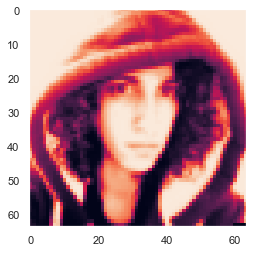

In [18]:
indx = 0
image = all_images[indx,:,:]
predict( model_deep, image, True )

Model Prediction: NOT CRIMINAL with probability = 0.01


0

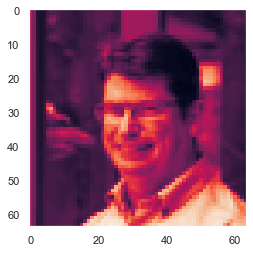

In [19]:
indx = 1
image = all_images[indx,:,:]
predict( model_deep, image, True )

Let's try the same thing, but without using the convolutional networks:

You can also make an analysis of your results in terms of different evaluation metrics by calling the function *classification_report*

In [20]:
from sklearn.metrics import classification_report

results = []
for indx in range(0, len(X_test)):
    
    image = X_test[indx,:,:,0]
    r = predict( model_deep, image, False )
    results.append(r)

In [21]:
names=['NOT CRIMINAL', 'CRIMINAL']
print(classification_report(y_test.values, results, target_names=names))

              precision    recall  f1-score   support

NOT CRIMINAL       0.99      0.97      0.98       320
    CRIMINAL       0.97      0.99      0.98       323

    accuracy                           0.98       643
   macro avg       0.98      0.98      0.98       643
weighted avg       0.98      0.98      0.98       643



You can also visuallize this, using the confusion matrix

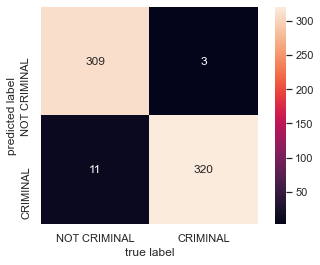

In [23]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, results)
sns.heatmap(mat.T, square=True, fmt='d', cbar=True, xticklabels=names, \
            yticklabels=names, annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Let's take a look at some pixels...

In [24]:
last_pixels = check_image_dataset( faces_dataset, "target" )

# and let's separate between CRIMINAL taget = 1 ...
criminal_last_pixels = last_pixels[ last_pixels["target"] == 1 ]
criminal_last_pixels.head(10)

,pixel_4092,pixel_4093,pixel_4094,pixel_4095,target
0,0,0,0,0,1
2,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,0,1
8,0,0,0,0,1
9,0,0,0,0,1
10,0,0,0,0,1
11,0,0,0,0,1


In [25]:
# ... and NOT CRIMINAL target = 0
ncriminal_last_pixels = last_pixels[ last_pixels["target"] == 0 ]
ncriminal_last_pixels.head(10)

,pixel_4092,pixel_4093,pixel_4094,pixel_4095,target
1,177,171,169,162,0
3,1,1,1,1,0
13,190,189,190,189,0
15,99,98,97,94,0
16,155,134,103,71,0
17,229,247,185,179,0
18,1,1,1,1,0
22,123,122,121,117,0
23,76,95,140,147,0
26,97,94,93,110,0


### What do you think about this?

Answer:

## Group Discussion:

- Q1. What is the major problem with the design of this model?

**Answer:**

- Q2. What are the major consequences of the application of this model if people use it as a black box?

**Answer:**

- Q3. How could we do this correctly?

**Answer:**

